<h1 align="center">Credit Card Lead Prediction</h1>

## Problem Statement

**Description:** Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.



The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 



In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.

Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

* Customer details (gender, age, region etc.)
* Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)

### Data Dictionary

<img src="data/train_data_dict.PNG"/>

<img src="data/test_data_dict.PNG"/>

### Public and Private Split

Test data is further divided into Public 30% and Private 70%

### Evaluation
The evaluation metric for this competition is **roc_auc_score** across all entries in the test set.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import StackingClassifier,RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler,Normalizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score,confusion_matrix
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import SMOTE,RandomOverSampler
from sklearn.svm import SVC
import tensorflow as tf
from scipy.sparse import hstack
warnings.filterwarnings(action="ignore")

In [3]:
#loading training datasets
train_df=pd.read_csv("data/train_s3TEQDk.csv")
train_df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [4]:
print("List of columns::",train_df.columns.values)

List of columns:: ['ID' 'Gender' 'Age' 'Region_Code' 'Occupation' 'Channel_Code' 'Vintage'
 'Credit_Product' 'Avg_Account_Balance' 'Is_Active' 'Is_Lead']


In [5]:
duplicated_rows=sum(train_df.duplicated(subset=['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active','Is_Lead']))
print("Number of duplicate rows based on sub groups of columns:: ",duplicated_rows)

Number of duplicate rows based on sub groups of columns::  21


In [6]:
# Deleting duplicates rows
train_df.drop_duplicates(subset=['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active','Is_Lead'],keep="first",inplace=True)

In [7]:
#  training data infomation
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245704 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245704 non-null  object
 1   Gender               245704 non-null  object
 2   Age                  245704 non-null  int64 
 3   Region_Code          245704 non-null  object
 4   Occupation           245704 non-null  object
 5   Channel_Code         245704 non-null  object
 6   Vintage              245704 non-null  int64 
 7   Credit_Product       216379 non-null  object
 8   Avg_Account_Balance  245704 non-null  int64 
 9   Is_Active            245704 non-null  object
 10  Is_Lead              245704 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 22.5+ MB


In [8]:
# Ques: How much data points are missing in every feature(percentage) 
train_df.isna().sum()/train_df.shape[0]

ID                     0.000000
Gender                 0.000000
Age                    0.000000
Region_Code            0.000000
Occupation             0.000000
Channel_Code           0.000000
Vintage                0.000000
Credit_Product         0.119351
Avg_Account_Balance    0.000000
Is_Active              0.000000
Is_Lead                0.000000
dtype: float64

**Observation**
* Number of data points in train datasets: 245725
* Only credit_product column has missing data points.
* Around 12% of data points are missing in Credit Product feature

**Ques:** How can we fill this missing this value

There are many way to fill Missing value.
* most common category
* Predict with trained model 
* With Domain knowledge
* Assume NaN as another category





In [9]:
#trying to find pattern how can we fill NaN values
train_df[train_df["Credit_Product"].isna()].head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
6,ETQCZFEJ,Male,62,RG282,Other,X3,20,NaN,1056750,Yes,1
15,UJ2NJKKL,Male,33,RG268,Self_Employed,X2,69,NaN,517063,Yes,1
31,ABPMK4WU,Female,32,RG279,Salaried,X4,15,NaN,1072850,Yes,1
36,MTEIXMB9,Female,41,RG268,Self_Employed,X3,62,NaN,962383,No,1
40,6WX9JDVK,Female,63,RG254,Other,X3,103,NaN,1249319,Yes,1


In [10]:
train_df[train_df['Credit_Product']=="Yes"].head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
9,NVKTFBA2,Female,55,RG268,Self_Employed,X2,49,Yes,2014239,No,0
11,GZ5TMYIR,Male,27,RG270,Self_Employed,X1,14,Yes,502787,No,0
13,KCE7JSFN,Male,31,RG254,Salaried,X1,31,Yes,938754,No,0
16,CNGSPYWS,Female,46,RG268,Other,X3,97,Yes,2282502,No,1
17,VH7NBNNQ,Female,59,RG283,Other,X3,15,Yes,2384692,No,1


In [11]:
train_df[train_df['Credit_Product']=="No"].head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [12]:
#Let see value count 
train_df['Credit_Product'].value_counts(normalize=True)

No     0.667075
Yes    0.332925
Name: Credit_Product, dtype: float64

**Observation:**

* Above we can see that around 66% of data points have "No" as value so we can fill missing value with "No"
* or we can use some model which will train with other feature as independent variable  and credit product as dependent variable
* or we can consider "NaN" as category if above idea doesn't work well for training Models

## Exploratory Data Analysis [EDA]

### Balanced or Imbalanced Dataset


In [13]:
train_df.Is_Lead.value_counts(normalize=True)

0    0.762771
1    0.237229
Name: Is_Lead, dtype: float64

**Observation**

* It's Imbalanced Dataset so we can try SMOTE technique as Over sampling.
* Or we can try class_weight parameter in models


### Gender Feature Analysis

In [14]:
# Gender Feature distribution 
print("{}% of Male data present in this dataset.".format(round(train_df["Gender"].value_counts(normalize=True)[0]*100)))
print("{}% of Female data present in this dataset.".format(round(train_df["Gender"].value_counts(normalize=True)[1]*100)))

55% of Male data present in this dataset.
45% of Female data present in this dataset.


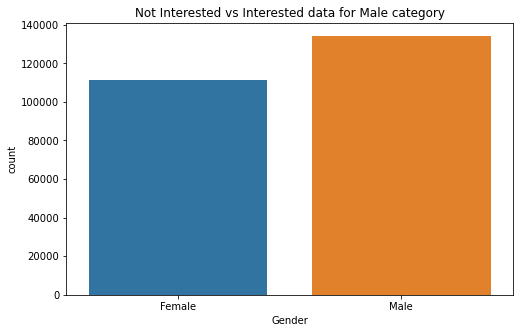

In [15]:
plt.figure(figsize=(8,5))
plt.title("Not Interested vs Interested data for Male category")
sns.countplot(train_df["Gender"])
plt.show()

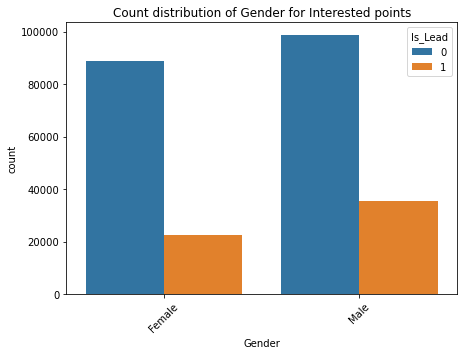

In [16]:
plt.figure(figsize=(7,5))
plt.title("Count distribution of Gender for Interested points")
sns.countplot(x=train_df["Gender"],hue=train_df["Is_Lead"])
plt.xticks(rotation=45)
plt.show()

**Observation**
* this dataset has 55% of male and 45% of female data points
* Female are less interested than Male 

### Age Feature Analysis

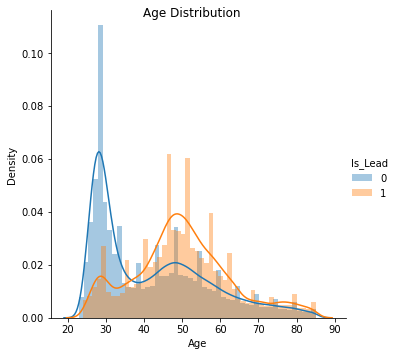

In [17]:
g=sns.FacetGrid(train_df,height=5,hue="Is_Lead").map(sns.distplot,"Age").add_legend()
g.fig.suptitle("Age Distribution")
plt.show()

**Observation:**
* Age distribution for "Not Interested" and "Inrerested" are overlapping.
* It seems that who has age less than 35 is more "not intereseted" for credit card.
* who have age >35 and age < 65 are more "Interested" for credit card.
* and Age > 65 have almost equal interest for creadit card.
* Based on this analogy we can convert this feature into categorical variable.

**Convert to category**
* based on above analogy, this feature will be converted into category with below strategy.
* 0-35='age_grp1',35-42:'age_grp2',42-65:'age_grp3',65-above:'age_grp4'

### Avg_Account_Balance Feature Analysis

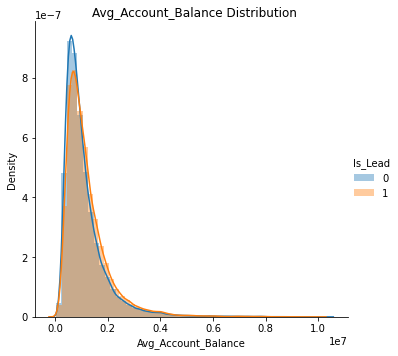

In [18]:
g=sns.FacetGrid(train_df,height=5,hue="Is_Lead").map(sns.distplot,"Avg_Account_Balance").add_legend()
g.fig.suptitle("Avg_Account_Balance Distribution")
plt.show()

**Observation:**
* distribution of Avg_Account_Balance for both Is_Lead categories are almost same.
* we can see a little pick for "not interested" person who belongs between 0.0 and 0.2 range of avg acc balanced(x-axis).
* so we will add this feature for training the model and will see it is helping to improve model or not.

### Vintage Feature Analysis

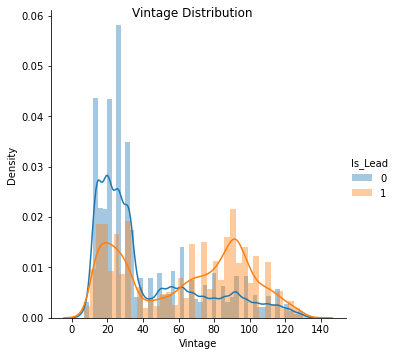

In [19]:
g=sns.FacetGrid(train_df,height=5,hue="Is_Lead").map(sns.distplot,"Vintage").add_legend()
g.fig.suptitle("Vintage Distribution")
plt.show()

**Observation:**
* Vintage distribution for "Not Interested" and "Inrerested" are overlapping.
* between vintage >0 and vintage <40 has more probability to "Not Interested" for credit card.
* between vintage >40 and vintage <60 has bit more probability to "Not Interested" for credit card but alomost overlapping.
* between vintage >40 and vintage <120 has more probability to "Interested" for credit card.
* between vintage >120 and above has almost same probabilty for both Is_lead category.
* Based on this analogy we can convert this feature into categorical variable.

**Convert to category**
* based on above analogy, this feature will be converted into category with below strategy.
* 0-40='vint_g1',40-60='vint_g2',60-80='vint_g3',80-100='vint_g4',100-120='vint_g5',120-above='vint_g6']

### Region_Code feature

In [20]:
print("Number of Unique Region_Code :",len(train_df['Region_Code'].unique()))

Number of Unique Region_Code : 35


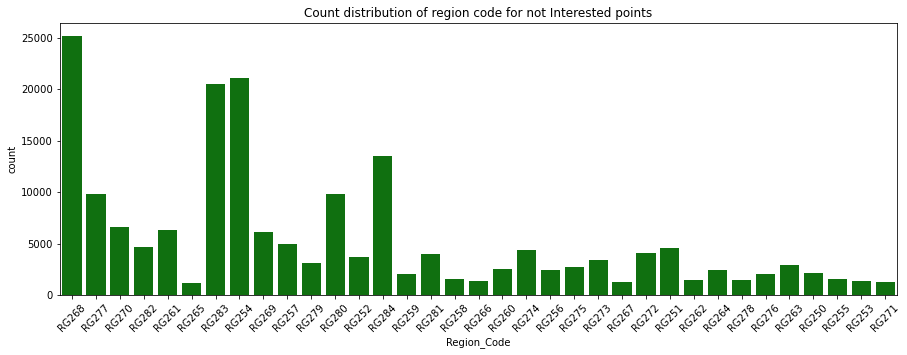

In [21]:
plt.figure(figsize=(15,5))
plt.title("Count distribution of region code for not Interested points")
sns.countplot(x=train_df[train_df["Is_Lead"]==0]["Region_Code"],color='green')
plt.xticks(rotation=45)
plt.show()

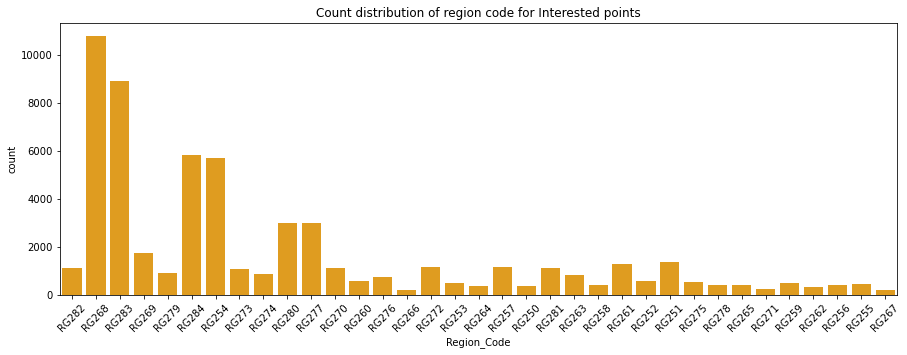

In [22]:
plt.figure(figsize=(15,5))
plt.title("Count distribution of region code for Interested points")
sns.countplot(x=train_df[train_df["Is_Lead"]==1]["Region_Code"],color='orange')
plt.xticks(rotation=45)
plt.show()

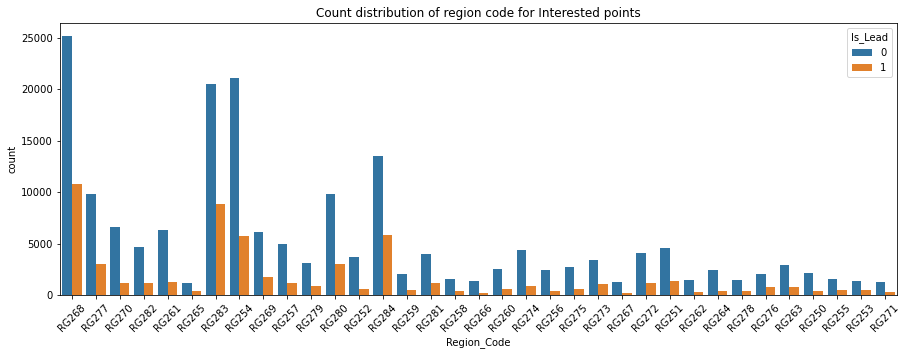

In [23]:
plt.figure(figsize=(15,5))
plt.title("Count distribution of region code for Interested points")
sns.countplot(x=train_df["Region_Code"],hue=train_df["Is_Lead"])
plt.xticks(rotation=45)
plt.show()

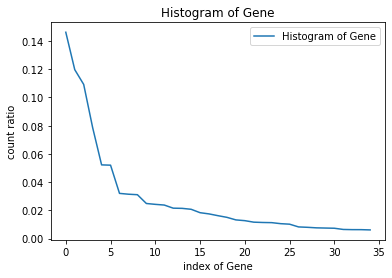

In [24]:
unique_gene_count=train_df['Region_Code'].value_counts(normalize=True,sort=True)
plt.plot(unique_gene_count.values,label="Histogram of Gene")
plt.title("Histogram of Gene")
plt.xlabel("index of Gene")
plt.ylabel("count ratio")
# plt.xticks([0,50,100,150,200,250])
plt.legend()
plt.show()

**Observation:**
* In few region, counts are very high and the number of "not Interested" and "Interested" counts are also high in those region.
* we will convert it into vector using **One Hot Encoding** and  will see how much helpful for models.
* And also we can trying by converting into category region group and will see how much helpful for our models.

In [25]:
#Creating reference region group category dictionary
ref_reg=train_df["Region_Code"].value_counts()
ref_reg_ind=ref_reg.index
reg_cat_dict=dict()
[reg_cat_dict.update({i:"reg_cat1"}) for i in ref_reg_ind[:5]]
[reg_cat_dict.update({i:"reg_cat2"}) for i in ref_reg_ind[5:15]]
[reg_cat_dict.update({i:"reg_cat3"}) for i in ref_reg_ind[15:25]]
[reg_cat_dict.update({i:"reg_cat4"}) for i in ref_reg_ind[25:]]
print("Tried these category but It does not work well for models")

Tried these category but It does not work well for models


### Occupation Analysis

In [26]:
train_df.Occupation.value_counts(normalize=True)

Self_Employed    0.410583
Salaried         0.292970
Other            0.285592
Entrepreneur     0.010855
Name: Occupation, dtype: float64

In [27]:
print("Number of Unique Region_Code :",len(train_df['Occupation'].unique()))

Number of Unique Region_Code : 4


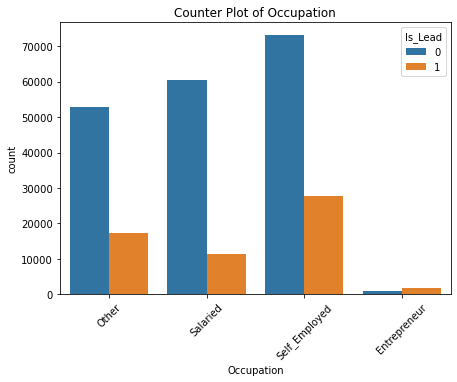

In [28]:
plt.figure(figsize=(7,5))
plt.title("Counter Plot of Occupation")
sns.countplot(x=train_df["Occupation"],hue=train_df["Is_Lead"])
plt.xticks(rotation=45)
plt.show()

**Observation**
* Entrepreneur are more interested for credit card over not interested Entrepreneur
* Other category are more likely to interested for credit card than salaried category

### Channel_Code Analysis

In [29]:
print("Number of Unique Region_Code :",len(train_df['Channel_Code'].unique()))

Number of Unique Region_Code : 4


In [30]:
train_df.Channel_Code.value_counts(normalize=True)

X1    0.422061
X3    0.279645
X2    0.275628
X4    0.022665
Name: Channel_Code, dtype: float64

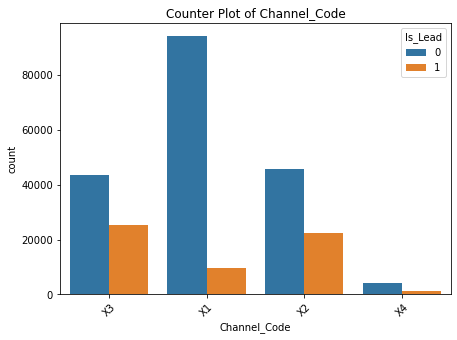

In [31]:
plt.figure(figsize=(7,5))
plt.title("Counter Plot of Channel_Code")
sns.countplot(x=train_df["Channel_Code"],hue=train_df["Is_Lead"])
plt.xticks(rotation=45)
plt.show()

**Observation**
* We have very less data points for category X4.It's around 2 % of whole data.
* users who belongs to X1 channel are more likely to "Not interested" for credit card over "interested" X1 Channel


### Credit_Product analysis

In [32]:
print("Number of Unique Region_Code :",len(train_df['Credit_Product'].unique()))

Number of Unique Region_Code : 3


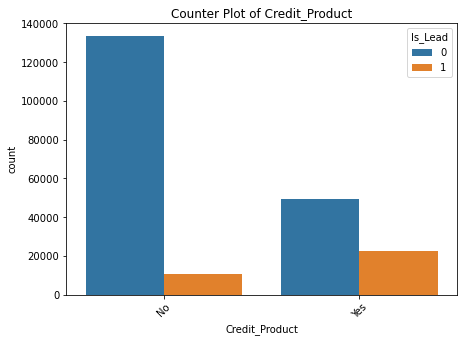

In [33]:
plt.figure(figsize=(7,5))
plt.title("Counter Plot of Credit_Product")
sns.countplot(x=train_df["Credit_Product"],hue=train_df["Is_Lead"])
plt.xticks(rotation=45)
plt.show()

**Obsevation:**
* There are two categories for credit product ("Yes" and "No") along with some missing value
* so for filling missing data points, we will consider third category which will be NaN.
* user who have any active product(like Home Loan) are more likely to "Interested" for credit card rather than who have not any active product.


### Is_Active analysis

In [34]:
print("Number of Unique Region_Code :",len(train_df['Is_Active'].unique()))

Number of Unique Region_Code : 2


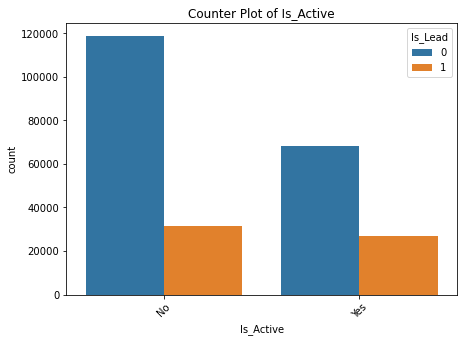

In [35]:
plt.figure(figsize=(7,5))
plt.title("Counter Plot of Is_Active")
sns.countplot(x=train_df["Is_Active"],hue=train_df["Is_Lead"])
plt.xticks(rotation=45)
plt.show()

**Observation:**
* user who is active < 3 months are more likely to Interested for credit card rather than who is not active.

## Preparing Data

In [36]:
train_df[train_df.Is_Lead==1]["Credit_Product"].value_counts()

Yes    22690
No     10623
Name: Credit_Product, dtype: int64

In [37]:
train_df[train_df.Is_Lead==0]["Credit_Product"].value_counts()

No     133718
Yes     49348
Name: Credit_Product, dtype: int64

**Note:**
* most frequent category of credit_product for not interested people is "No"
* most frequent category of credit_product for Interested people is "Yes"
* we can fill data point with this observation but it dooes not work well so I choose "NaN" as third category for all missing datapoints


In [38]:
# Defining function for preprocessing and Feature Engineering 
def preprocessed_data(data):
    #Converted Age into category feature
    data["Age_group"]=pd.cut(data.Age,bins=[0,35,45,65,120],labels=['age_grp1','age_grp2','age_grp3','age_grp4'])
    #Converted Vintage into category feature
    data["Vint_group"]=pd.cut(data.Vintage,bins=[0,40,60,80,100,120,200],labels=['vint_g1','vint_g2','vint_g3','vint_g4','vint_g5','vint_g6'])
    #Concating Two feature that may help to imporve model accuracy
    data["Credit_Product"]=data["Credit_Product"].fillna("Nan")
    data["age_vintage"]=[temp[0]+"_"+temp[1] for temp in data[["Age_group","Vint_group"]].values]
    data["age_credit"]=[temp[0]+"_"+temp[1] for temp in data[["Age_group","Credit_Product"]].values]
    data["region_credit"]=[temp[0]+"_"+temp[1] for temp in data[["Region_Code","Credit_Product"]].values]
    
    #dropping Age and Vintage after converted into category features
    data.drop(columns=["Age","Vintage"],inplace=True)
    return data

In [39]:
#Preprocessing training data
train_df=preprocessed_data(train_df)
train_df.head()

,ID,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Age_group,Vint_group,age_vintage,age_credit,region_credit
0,NNVBBKZB,Female,RG268,Other,X3,No,1045696,No,0,age_grp4,vint_g2,age_grp4_vint_g2,age_grp4_No,RG268_No
1,IDD62UNG,Female,RG277,Salaried,X1,No,581988,No,0,age_grp1,vint_g1,age_grp1_vint_g1,age_grp1_No,RG277_No
2,HD3DSEMC,Female,RG268,Self_Employed,X3,No,1484315,Yes,0,age_grp3,vint_g1,age_grp3_vint_g1,age_grp3_No,RG268_No
3,BF3NC7KV,Male,RG270,Salaried,X1,No,470454,No,0,age_grp1,vint_g1,age_grp1_vint_g1,age_grp1_No,RG270_No
4,TEASRWXV,Female,RG282,Salaried,X1,No,886787,No,0,age_grp1,vint_g1,age_grp1_vint_g1,age_grp1_No,RG282_No


In [40]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245704 entries, 0 to 245724
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   ID                   245704 non-null  object  
 1   Gender               245704 non-null  object  
 2   Region_Code          245704 non-null  object  
 3   Occupation           245704 non-null  object  
 4   Channel_Code         245704 non-null  object  
 5   Credit_Product       245704 non-null  object  
 6   Avg_Account_Balance  245704 non-null  int64   
 7   Is_Active            245704 non-null  object  
 8   Is_Lead              245704 non-null  int64   
 9   Age_group            245704 non-null  category
 10  Vint_group           245704 non-null  category
 11  age_vintage          245704 non-null  object  
 12  age_credit           245704 non-null  object  
 13  region_credit        245704 non-null  object  
dtypes: category(2), int64(2), object(10)
memory usage: 3

In [41]:
X=train_df.drop(columns=["Is_Lead","ID"])
y=train_df.Is_Lead.values

### Split into Train and CV data

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,stratify=y,random_state=8)

In [43]:
# X_train=X
# y_train=y

In [44]:
#Creating List of columns of all category features
category_var=list(X_train.select_dtypes(include=["object","category"]).columns.values)

In [45]:
#Fitting Encoder and Normalizer so that we can use it to transform train, cv and test data 
encoder=OneHotEncoder(drop="first")
encoder.fit(X_train[category_var])
#Normalizer fitting
# we can also  use StandardScaler here
norm=Normalizer()
norm.fit(X_train["Avg_Account_Balance"].values.reshape(-1,1))


Normalizer()

In [46]:
## Making list of All features
features_name=list(encoder.get_feature_names())
features_name.append("Avg_Account_Balance")

In [47]:
# create a function to convert cotegory data to vector and Normalized the continuous variables
def encode_dataset(data):
    category_data=encoder.transform(data[category_var])
    numeric_norm=norm.transform(data["Avg_Account_Balance"].values.reshape(-1,1))
    # concating category data and Numerical feature
    data=hstack((category_data,numeric_norm))
    print("data shape: ",data.shape)
    return data


In [48]:
X_train=encode_dataset(X_train)
X_test=encode_dataset(X_test)

data shape:  (184278, 189)
data shape:  (61426, 189)


In [49]:
print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)

X_train shape: (184278, 189)
X_test shape: (61426, 189)


In [50]:
#define a function which helps to preprocess ,feature engineering and encode into vectors
def preprocess_and_encode_test_data(data):
    data=preprocessed_data(data)
    data=encode_dataset(data)
    return data

## Model Training

### Random Forest Classifier

In [51]:
#Hyper parameter tunning to RandomForestClassifier
param={"n_estimators":[100,120,150,200]}
model=RandomForestClassifier(class_weight="balanced",max_depth=10,n_jobs=-1)
# model.fit(X_train,y_train)
clf=GridSearchCV(estimator=model,param_grid=param,scoring="roc_auc",verbose=1)
clf.fit(X_train,y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=10, n_jobs=-1),
             param_grid={'n_estimators': [100, 120, 150, 200]},
             scoring='roc_auc', verbose=1)

In [52]:
rf_param=clf.best_params_
print("Tunned Parameter of RF:",rf_param)
model=RandomForestClassifier(max_depth=10
                   ,n_estimators=rf_param["n_estimators"],class_weight="balanced",n_jobs=-1)
model.fit(X_train,y_train)


Tunned Parameter of RF: {'n_estimators': 150}


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=150,
                       n_jobs=-1)

#### Top 50 Feature (Featuere_Important) 

In [53]:
## Selecting Top 50 Features
no_of_features=50
features_dict=dict(zip(features_name,model.feature_importances_))
features_dict=sorted(features_dict.items(), key=lambda x: x[1], reverse=True)
def get_important_feature(top=10):
    features=[feat[0] for feat in features_dict[:top]]
    return features
important_feature=get_important_feature(no_of_features)
important_feature_index=[features_name.index(item) for item in important_feature]

In [54]:
print("#"*10,"Top Features","#"*10)
print(important_feature)

########## Top Features ##########
['x4_No', 'x9_age_grp1_No', 'x9_age_grp3_Nan', 'x6_age_grp3', 'x7_vint_g4', 'x9_age_grp3_No', 'x9_age_grp2_Nan', 'x4_Yes', 'x3_X3', 'x8_age_grp3_vint_g4', 'x10_RG268_Nan', 'x9_age_grp3_Yes', 'x2_Salaried', 'x9_age_grp4_Nan', 'x3_X2', 'x9_age_grp2_No', 'x9_age_grp1_Yes', 'x10_RG283_Nan', 'x5_Yes', 'x10_RG268_No', 'x6_age_grp2', 'x9_age_grp2_Yes', 'x10_RG284_Nan', 'x10_RG283_No', 'x10_RG254_Nan', 'x10_RG254_No', 'x7_vint_g3', 'x9_age_grp4_No', 'x2_Self_Employed', 'x8_age_grp3_vint_g5', 'x8_age_grp2_vint_g1', 'x7_vint_g2', 'x8_age_grp3_vint_g3', 'x8_age_grp4_vint_g4', 'x6_age_grp4', 'x10_RG284_No', 'x10_RG280_Nan', 'x8_age_grp3_vint_g2', 'x8_age_grp3_vint_g1', 'x0_Male', 'x7_vint_g5', 'x8_age_grp2_vint_g4', 'x2_Other', 'x10_RG277_Nan', 'x1_RG268', 'x10_RG268_Yes', 'x10_RG277_No', 'x10_RG280_No', 'x8_age_grp2_vint_g3', 'x9_age_grp4_Yes']


In [55]:
#Extracting top 50 features
def extract_important_features(data):
    return data.tocsr()[:,important_feature_index]
X_train_imp=extract_important_features(X_train)
X_test_imp=extract_important_features(X_test)

#### 1. RandomForestClassifier on all data

In [56]:
model=RandomForestClassifier(max_depth=10
                   ,n_estimators=rf_param["n_estimators"],class_weight="balanced",n_jobs=-1)
model.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=150,
                       n_jobs=-1)

In [57]:
#AUC on training data
pred=model.predict_proba(X_train)
auc=roc_auc_score(y_train,pred[:, 1])
print("Train AUC:",auc)

Train AUC: 0.8659737803098613


In [58]:
#AUC on cross validation data
pred=model.predict_proba(X_test)
auc=roc_auc_score(y_test,pred[:, 1])
print("Test AUC:",auc)

Test AUC: 0.8664393102039625


#### 2. RandomForestClassifier on Top 50 features

In [59]:
model=RandomForestClassifier(max_depth=10
                   ,n_estimators=rf_param["n_estimators"],class_weight="balanced",n_jobs=-1)
model.fit(X_train_imp,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=150,
                       n_jobs=-1)

In [60]:
#AUC on training data
pred=model.predict_proba(X_train_imp)
auc=roc_auc_score(y_train,pred[:, 1])
print("Train AUC:",auc)

Train AUC: 0.8708094403670058


In [61]:
#AUC on cross validation data
pred=model.predict_proba(X_test_imp)
auc=roc_auc_score(y_test,pred[:, 1])
print("Test AUC:",auc)

Test AUC: 0.8709047009451487


### SGDClassifier

In [62]:
alpha=[10**i for i in range(-4,0)]
param={"alpha":alpha,"penalty":['l2', 'l1', 'elasticnet']}
model=SGDClassifier(loss="log",class_weight="balanced",learning_rate="optimal")
#     model.fit(X_train,y_train)
clf=GridSearchCV(estimator=model,param_grid=param,scoring="roc_auc",verbose=1)
clf.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=SGDClassifier(class_weight='balanced', loss='log'),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             scoring='roc_auc', verbose=1)

In [63]:
sgd_param=clf.best_params_
sgd_param


{'alpha': 0.001, 'penalty': 'l2'}

#### 1. SGDClassifier on All features

In [64]:
model=SGDClassifier(loss="log",class_weight="balanced",learning_rate="optimal",alpha=sgd_param["alpha"],penalty=sgd_param["penalty"])
model.fit(X_train,y_train)

SGDClassifier(alpha=0.001, class_weight='balanced', loss='log')

In [65]:
#AUC on training data
pred=model.predict_proba(X_train)
auc=roc_auc_score(y_train,pred[:, 1])
print("Train AUC:",auc)

Train AUC: 0.8645218412206594


In [66]:
#AUC on cross validation data
pred=model.predict_proba(X_test)
auc=roc_auc_score(y_test,pred[:, 1])
print("Test AUC:",auc)

Test AUC: 0.8674847268533024


#### 2. SGDClassifier on Top 50 features

In [67]:
model=SGDClassifier(loss="log",class_weight="balanced",learning_rate="optimal",alpha=sgd_param["alpha"],penalty=sgd_param["penalty"])
model.fit(X_train_imp,y_train)

SGDClassifier(alpha=0.001, class_weight='balanced', loss='log')

In [68]:
#AUC on training data
pred=model.predict_proba(X_train_imp)
auc=roc_auc_score(y_train,pred[:, 1])
print("Train AUC:",auc)

Train AUC: 0.8629184442762036


In [69]:
#AUC on cross validation data
pred=model.predict_proba(X_test_imp)
auc=roc_auc_score(y_test,pred[:, 1])
print("Test AUC:",auc)

Test AUC: 0.8659755233259679


### XGBOOST Classifier

In [70]:
#Hyper Tunning for XGBoostClassifier
param={"n_estimators":[100,120,150],"reg_lambda":[0.1,0.05]}
model=XGBClassifier(scale_pos_weight=3,eval_metric="logloss",learning_rate=0.1,max_depth=5)

clf=GridSearchCV(estimator=model,param_grid=param,scoring="roc_auc",verbose=1)
clf.fit(X_train_imp,y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                 

In [71]:
xgb_param=clf.best_params_
xgb_param

{'n_estimators': 100, 'reg_lambda': 0.1}

#### 1. XGBClassifier on all Features

In [72]:
model=XGBClassifier(eval_metric="logloss",max_depth=5,reg_lambda=xgb_param["reg_lambda"]
                    ,learning_rate=0.1,n_estimators=xgb_param["n_estimators"])
model.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [73]:
#AUC on training data
pred=model.predict_proba(X_train)
auc=roc_auc_score(y_train,pred[:, 1])
print("Train AUC:",auc)

Train AUC: 0.8736070816282663


In [74]:
#AUC on cross validation data
pred=model.predict_proba(X_test)
auc=roc_auc_score(y_test,pred[:, 1])
print("CV AUC:",auc)

CV AUC: 0.87362973327029


#### 2. XGBClassifier on Top 50 Features

In [75]:
model=XGBClassifier(eval_metric="logloss",max_depth=5,reg_lambda=xgb_param["reg_lambda"]
                    ,learning_rate=0.1,n_estimators=xgb_param["n_estimators"])
model.fit(X_train_imp,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [76]:
#AUC on training data
pred=model.predict_proba(X_train_imp)
auc=roc_auc_score(y_train,pred[:, 1])
print("Train AUC:",auc)

Train AUC: 0.8730313223410271


In [77]:
#AUC on cross validation data
pred=model.predict_proba(X_test_imp)
auc=roc_auc_score(y_test,pred[:, 1])
print("CV AUC:",auc)

CV AUC: 0.873803272448727


### StackingClassifier

#### 1. StackingClassifier on all features

In [78]:
# param={"n_estimators":[50,100],"max_depth":[5,10,15]}
clf1=model=XGBClassifier(eval_metric="auc",learning_rate=0.1,max_depth=5
                   ,n_estimators=xgb_param["n_estimators"],reg_lambda=xgb_param["reg_lambda"])
clf2=SGDClassifier(loss="log",class_weight="balanced",learning_rate="optimal",alpha=sgd_param["alpha"],penalty=sgd_param["penalty"])

clf3=RandomForestClassifier(max_depth=10
                   ,n_estimators=100,class_weight="balanced",n_jobs=-1)

lr_clf=LogisticRegression()
model=StackingClassifier(estimators=[("xgb",clf1),("sgd",clf2),("rf",clf3)],final_estimator=lr_clf)
model.fit(X_train,y_train)
# clf=GridSearchCV(estimator=model,param_grid=param,scoring="roc_auc",verbose=1)
# clf.fit(X_train,y_train)


StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              enable_categorical=False,
                                              eval_metric='auc', gamma=None,
                                              gpu_id=None, importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1,
                                              max_delta_step=None, max_depth=5,
                                              min_child_weight=None,
                                              missing=nan,
                                              mo...
                                             

In [79]:
#AUC on training data
pred=model.predict_proba(X_train)
auc=roc_auc_score(y_train,pred[:, 1])
print("Train AUC:",auc)

Train AUC: 0.8724306720416939


In [80]:
#AUC on cross validation data
pred=model.predict_proba(X_test)
auc=roc_auc_score(y_test,pred[:, 1])
print("CV AUC:",auc)

CV AUC: 0.8729916565802007


#### 2. StackingClassifier on Top 50 Features

In [81]:
# param={"n_estimators":[50,100],"max_depth":[5,10,15]}
clf1=model=XGBClassifier(eval_metric="auc",learning_rate=0.1,max_depth=5
                   ,n_estimators=xgb_param["n_estimators"],reg_lambda=xgb_param["reg_lambda"])
clf2=SGDClassifier(loss="log",class_weight="balanced",learning_rate="optimal",alpha=sgd_param["alpha"],penalty=sgd_param["penalty"])

clf3=RandomForestClassifier(max_depth=10
                   ,n_estimators=100,class_weight="balanced",n_jobs=-1)

lr_clf=LogisticRegression()
model=StackingClassifier(estimators=[("xgb",clf1),("sgd",clf2),("rf",clf3)],final_estimator=lr_clf)
model.fit(X_train_imp,y_train)
# clf=GridSearchCV(estimator=model,param_grid=param,scoring="roc_auc",verbose=1)
# clf.fit(X_train,y_train)


StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              enable_categorical=False,
                                              eval_metric='auc', gamma=None,
                                              gpu_id=None, importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1,
                                              max_delta_step=None, max_depth=5,
                                              min_child_weight=None,
                                              missing=nan,
                                              mo...
                                             

In [82]:
#AUC on training data
pred=model.predict_proba(X_train_imp)
auc=roc_auc_score(y_train,pred[:, 1])
print("Train AUC:",auc)

Train AUC: 0.8729316136176766


In [83]:
#AUC on cross validation data
pred=model.predict_proba(X_test_imp)
auc=roc_auc_score(y_test,pred[:, 1])
print("Train AUC:",auc)

Train AUC: 0.8731234993405145


## Summary

In [97]:
from tabulate import tabulate
columns=["Model","Top_50 or All","Train auc","CV auc"]
summary=[["RandomForestClassifier","All",0.8659,0.8664],
         ["RandomForestClassifier","Top_50",0.8708,0.8709],
         ["SGDClassifier","All",0.8645,0.8674],
         ["SGDClassifier","Top_50",0.8629,0.8659],
         ["XGBClassifier","All",0.8736,0.8736],
         ["XGBClassifier","Top_50",0.8730,0.8738],
         ["StackingClassifier","All",0.8724,0.8729],
         ["StackingClassifier","Top_50",0.8729,0.8731],
        ]
summary_df=pd.DataFrame(summary,columns=columns)
#https://www.geeksforgeeks.org/display-the-pandas-dataframe-in-table-style/
print(tabulate(summary_df,headers="keys",tablefmt = 'psql'))

+----+------------------------+-----------------+-------------+----------+
|    | Model                  | Top_50 or All   |   Train auc |   CV auc |
|----+------------------------+-----------------+-------------+----------|
|  0 | RandomForestClassifier | All             |      0.8659 |   0.8664 |
|  1 | RandomForestClassifier | Top_50          |      0.8708 |   0.8709 |
|  2 | SGDClassifier          | All             |      0.8645 |   0.8674 |
|  3 | SGDClassifier          | Top_50          |      0.8629 |   0.8659 |
|  4 | XGBClassifier          | All             |      0.8736 |   0.8736 |
|  5 | XGBClassifier          | Top_50          |      0.873  |   0.8738 |
|  6 | StackingClassifier     | All             |      0.8724 |   0.8729 |
|  7 | StackingClassifier     | Top_50          |      0.8729 |   0.8731 |
+----+------------------------+-----------------+-------------+----------+


## Conclution

* Have trained many model where XGBClassifier works well 
* So I have chose XGBClassifier for predicting test data

### Best Model

In [89]:
model=XGBClassifier(eval_metric="logloss",max_depth=5,reg_lambda=xgb_param["reg_lambda"]
                    ,learning_rate=0.1,n_estimators=xgb_param["n_estimators"])
model.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [90]:
pred=model.predict_proba(X_test)
auc=roc_auc_score(y_test,pred[:, 1])
print("CV AUC:",auc)

CV AUC: 0.87362973327029


## Creating Submission File

In [91]:
#reading Test datasets
test_data=pd.read_csv("data/test_mSzZ8RL.csv")
print("Shape of test data::",test_data.shape)

Shape of test data:: (105312, 10)


In [92]:
#Test data preprocessing,feature engineering and converting into vectors 
test_df=preprocess_and_encode_test_data(test_data)

data shape:  (105312, 189)


In [93]:
y_pred=model.predict_proba(test_df)[:,1]
test_data["Is_Lead"]=y_pred

In [94]:
test_data=test_data[["ID","Is_Lead"]]

In [96]:
test_data.to_csv("output/final_submission.csv",index=False)